# Reinforcement learning for Electric Grid Optimization
### Reinforcement Learning Final Project | Author: Richard-John Lin, Xiangyue Wang

### 
## Environment Installation 
To start, let's install the environment in which our RL agent can learn from interactions. It runs under the Grid2op platform.

In [1]:
#pip install grid2op

Similarly the "baseline" python package can be installed with:

In [2]:
#pip install l2rpn-baselines

We will download all the packages that might be necessary, which are recorded in packages.txt

In [3]:
#pip install -r packages.txt

## Get the Data
Once grid2op is installed, we can get the competition data (approximately 2.0Gb) directly from the internet. training dataset which is what we will download. It contains 32 years of data, with 52 weeks in each each year, 7 days in each week and 288 steps in each day. The opponent used is the same on all the datasets (based on community feedback for the warmup set, we might adapt it for the validation and test set. It that is the case a communication will be made in due time). The current opponent uses the observation to chose which attack to perform. It does not use any information of the agent.

In [4]:
import grid2op
from tqdm.notebook import tqdm  # for easy progress bar
display_tqdm = False  # this is set to False for ease with the unitt test
from grid2op.PlotGrid import PlotMatplot #to visualize the grid
env = grid2op.make("l2rpn_wcci_2022", test=True) 

c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\Backend\PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\maxwa\anaconda3\envs\RL\python.exe -m pip install numba

  warnings.warn(
c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\MakeEnv\Make.py:393: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


## Inspect the Powergrird

Let's frist plot the layout of the grid to get an initial idea. This could be done using the function PlotMatplot from grid2op.

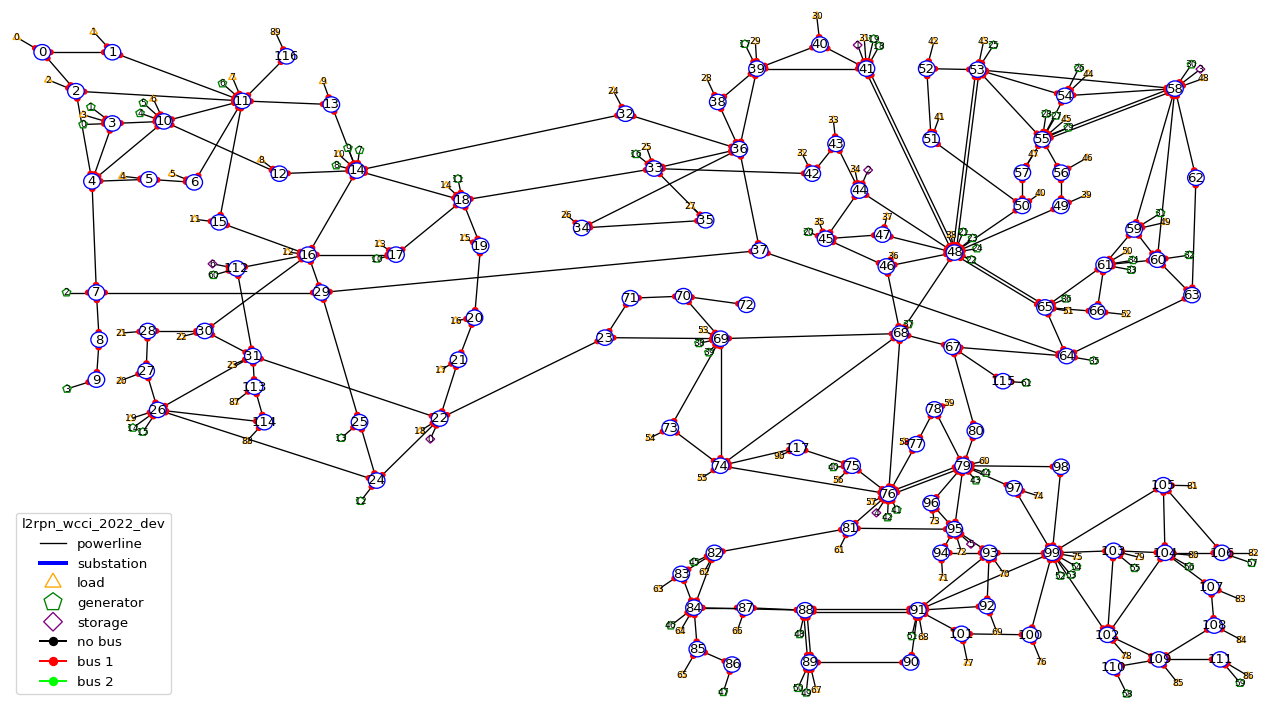

In [5]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_layout()

## Test Case 1: Create a Do-Nothing Agent
Now we have our environment setup, let's create our first reinforcement learning agent. There are **two main types of actions** in grid2op: Actions that change the status of powerlines (connected/disconnected) and actions that change the topology in a given substation. We will start with an agent that does nothing to test out if everything works.

In [6]:
from grid2op.Agent import DoNothingAgent
my_agent = DoNothingAgent(env.action_space)

We will run through the standarm gym loop and record the observations.

In [7]:
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
done = False
nb_step = 0

with tqdm(total=env.chronics_handler.max_timestep(), disable=not display_tqdm) as pbar:
    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

print("Number of timesteps computed: {}".format(nb_step))
print("Total maximum number of timesteps possible: {}".format(env.chronics_handler.max_timestep()))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Number of timesteps computed: 223
Total maximum number of timesteps possible: 288


The agent successfully managed to run the network 224 timesteps, while the episode could have lasted 288. Therefore, there has been a "game over".

We can investigate this by plotting the last observation. First, we need to create a utility object to make the plot:

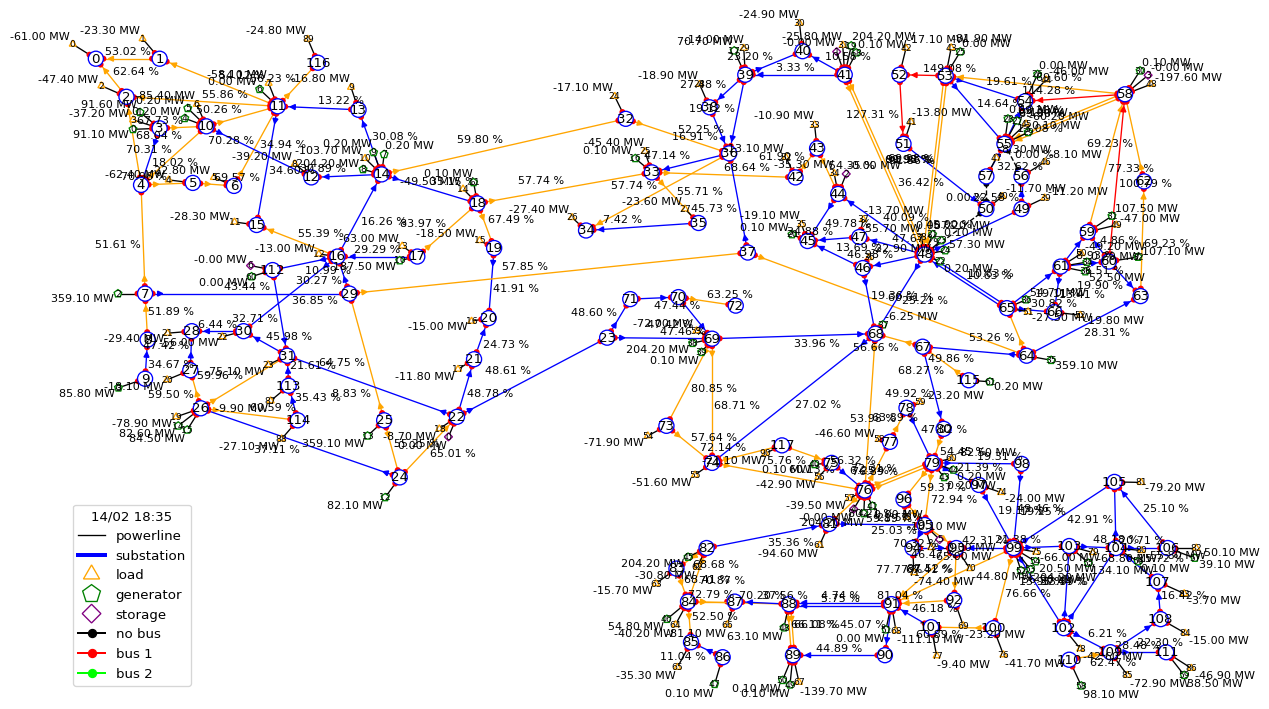

In [8]:
last_obs = all_obs[-1]
_ = plot_helper.plot_obs(last_obs)

Seems like the powerlines connecting substation 52 are overloaded, thus disconnecting the load (electrcity-using entities such as buildings) attached.

## Test Case 2: Baseline Agent (PPO-sb3)

Let's try the L2RPN-baseline model we imported! In perticular, we will try PPO with stable-baselines3.

In [9]:
#pip install stable-baselines3

In [10]:
from l2rpn_baselines.PPO_SB3 import train as ppo_train
from l2rpn_baselines.PPO_SB3 import evaluate as ppo_evaluate

import warnings
warnings.filterwarnings('ignore')

In [11]:
agent = ppo_train(env, name="PPO_SB3", save_path="baseline_PPO_SB3", iterations=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.27     |
|    ep_rew_mean     | 47.4     |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 776      |
|    total_timesteps | 2048     |
---------------------------------


Evaluate the stable-baseline model.

In [12]:
g2op_agent, res = ppo_evaluate(
                            env,
                            load_path="baseline_PPO_SB3/",
                            name="PPO_SB3",
                            nb_episode=10,
                            obs_space_kwargs={},
                            act_space_kwargs={}
                          )
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)

chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288


That is some miserable performance!

### Test Case 3: Double Dueling DQN
There are some past winning solutions stored in the baseline package. Let's try one of them out.

In [16]:
from l2rpn_baselines.DoubleDuelingDQN import train as DDDQN_train
from l2rpn_baselines.DoubleDuelingDQN import evaluate as DDDQN_evaluate

In [24]:
agent = DDDQN_train(env, name="DoubleDuelingDQN", save_path="baseline_DDDQN", iterations=10)

Step [0] -- Random [0.99]
Survived [1] steps
Total reward [204.8893585205078]
Survived [2] steps
Total reward [421.2033386230469]
Survived [2] steps
Total reward [420.8732604980469]
Survived [0] steps
Total reward [-10.0]
Survived [3] steps
Total reward [635.9225158691406]
Survived [4] steps
Total reward [854.8155975341797]
Survived [0] steps
Total reward [-10.0]
Survived [4] steps
Total reward [855.4228515625]
Survived [2] steps
Total reward [421.1894073486328]
Survived [5] steps
Total reward [1073.7085571289062]
Survived [4] steps
Total reward [855.4176635742188]
Survived [0] steps
Total reward [-10.0]
Survived [7] steps
Total reward [1515.6813049316406]
Survived [5] steps
Total reward [1072.7218780517578]
Survived [2] steps
Total reward [421.19529724121094]
Survived [2] steps
Total reward [420.6664733886719]
Survived [4] steps
Total reward [855.4127197265625]
Survived [1] steps
Total reward [204.9014129638672]
Survived [1] steps
Total reward [204.9038543701172]
Survived [2] steps
To

In [26]:
g2op_agent, res = DDDQN_evaluate(
                            env,
                            load_path="baseline_DDDQN/DoubleDuelingDQN.h5",
                            # name="DoubleDuelingDQN",
                            nb_episode=10
                            # obs_space_kwargs={},
                            # act_space_kwargs={}
                          )
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)

KeyboardInterrupt: 

### Test Case 4: DQN from scratch using RLlib

In [ ]:
# import sys
# !$sys.executable -m pip install 'ray[rllib]' # Install RLLib
# !pip install tensorflow
# !pip install ray
# !pip install ray[tune]
# pip install dm_tree
# !pip install lz4

In [ ]:
!set HOME=

In [ ]:
pip install dm_tree

Note: you may need to restart the kernel to use updated packages.


In [ ]:
os.getenv("HOME", 'c:\\Users\\maxwa\\Desktop\\Spring_2023\\Reinforcement_Learning\\Final_Project\\grid_optimization') 

'c:\\Users\\maxwa\\Desktop\\Spring_2023\\Reinforcement_Learning\\Final_Project\\grid_optimization'

In [ ]:
import gym
import ray
import shutil
import os
class MyEnv(gym.Env):
    def __init__(self, env_config):
        import grid2op
        from grid2op.gym_compat import GymEnv
        from grid2op.gym_compat import BoxGymActSpace
        from grid2op.Reward import L2RPNReward


        # 1. create the grid2op environment
        if not "env_name" in env_config:
            raise RuntimeError("The configuration for RLLIB should provide the env name")
        nm_env = env_config["env_name"]
        del env_config["env_name"]
        self.env_glop = grid2op.make(nm_env, **env_config, reward_class=L2RPNReward)

        # 2. create the gym environment
        self.env_gym = GymEnv(self.env_glop)
        obs_gym = self.env_gym.reset()

        # 3. (optional) customize it (see section above for more information)
        ## customize action space
        self.env_gym.action_space = BoxGymActSpace(self.env_glop.action_space,
                                                     attr_to_keep=["redispatch", "curtail", "set_storage"])
        # The possible attribute you can provide in the "attr_to_keep" are:
        # - "redispatch"
        # - "set_storage"
        # - "curtail"
        # - "curtail_mw" (same effect as "curtail")

        ## customize observation space
        ob_space = self.env_gym.observation_space
        ob_space = ob_space.keep_only_attr(["rho"])
        
        self.env_gym.observation_space = ob_space

        # 4. specific to RLlib
        self.action_space = self.env_gym.action_space
        self.observation_space = self.env_gym.observation_space
        self.step_count = 0
        self.case_no = 0
        self.reward_sum = 0
        

    def reset(self):
        obs = self.env_gym.reset()
        self.case_no += 1
        self.reward_sum = 0
        return obs
    def step(self, action):
        self.step_count += 1
        obs, reward, done, info = self.env_gym.step(action)
        self.reward_sum += reward
        return obs, reward, done, info
CHECKPOINT_ROOT = "tmp/rllib"
shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

ray_results = os.getenv("HOME", 'c:\\Users\\maxwa\\Desktop\\Spring_2023\\Reinforcement_Learning\\Final_Project\\grid_optimization') + "/ray_results/"
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [ ]:
## Check this link for RLlib Training API: https://docs.ray.io/en/master/rllib-training.html
nb_step_train = 1

s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} saved {}"
for n in range(nb_step_train):  # remember: don't forge to change this number to perform an actual training !
    from ray.rllib.agents import ppo  # import the type of agents (Change accordingly for PPO / ARS / APPO / A3C / A2C)
    # fist initialize ray
    config = ppo.DEFAULT_CONFIG.copy()
    config["timesteps_per_iteration"] = 10
    config["num_workers"] = 1
    ray.init()
    try:
        # then define a "trainer" (Change accordingly for PPO / ARS / APPO / A3C / A2C)
        trainer = ppo.PPOTrainer(env=MyEnv, config={
            "env_config": {"env_name":"l2rpn_wcci_2022"},  # config to pass to env class
        })
        # and then train it for a given number of iteration
        for step in range(nb_step_train):
            result = trainer.train()
            
            file_name = trainer.save(CHECKPOINT_ROOT)

            print(s.format(
              n + 1,
              result["episode_reward_min"],
              result["episode_reward_mean"],
              result["episode_reward_max"],
              result["episode_len_mean"],
              file_name
            ))
            #print(pretty_print(result))
    finally:   
        # shutdown ray
        ray.shutdown()

2023-04-18 12:39:27,154	INFO worker.py:1553 -- Started a local Ray instance.
2023-04-18 12:39:30,960	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.MyEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.MyEnv'>').build()` instead. This will raise an error in the future!
(RolloutWorker pid=11708) c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\Backend\PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
(RolloutWorker pid=11708) 	c:\Users\maxwa\anaconda3\envs\RL\python.exe -m pip install numba
(RolloutWorker pid=11708) 
(RolloutWorker pid=11708)   warnings.warn(
(RolloutWorker pid=18628) c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\grid2op\Backend\PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
(RolloutWorker pid=18628) 	c:\Users\maxwa\anaconda3\envs\

ValueError: Traceback (most recent call last):
  File "c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\ray\rllib\utils\pre_checks\env.py", line 82, in check_env
    check_gym_environments(env)
  File "c:\Users\maxwa\anaconda3\envs\RL\lib\site-packages\ray\rllib\utils\pre_checks\env.py", line 139, in check_gym_environments
    raise ValueError(ERR_MSG_OLD_GYM_API.format(env, ""))
ValueError: Your environment (<MyEnv instance>) does not abide to the new gymnasium-style API!
From Ray 2.3 on, RLlib only supports the new (gym>=0.26 or gymnasium) Env APIs.

Learn more about the most important changes here:
https://github.com/openai/gym and here: https://github.com/Farama-Foundation/Gymnasium

In order to fix this problem, do the following:

1) Run `pip install gymnasium` on your command line.
2) Change all your import statements in your code from
   `import gym` -> `import gymnasium as gym` OR
   `from gym.space import Discrete` -> `from gymnasium.spaces import Discrete`

For your custom (single agent) gym.Env classes:
3.1) Either wrap your old Env class via the provided `from gymnasium.wrappers import
     EnvCompatibility` wrapper class.
3.2) Alternatively to 3.1:
 - Change your `reset()` method to have the call signature 'def reset(self, *,
   seed=None, options=None)'
 - Return an additional info dict (empty dict should be fine) from your `reset()`
   method.
 - Return an additional `truncated` flag from your `step()` method (between `done` and
   `info`). This flag should indicate, whether the episode was terminated prematurely
   due to some time constraint or other kind of horizon setting.

For your custom RLlib `MultiAgentEnv` classes:
4.1) Either wrap your old MultiAgentEnv via the provided
     `from ray.rllib.env.wrappers.multi_agent_env_compatibility import
     MultiAgentEnvCompatibility` wrapper class.
4.2) Alternatively to 4.1:
 - Change your `reset()` method to have the call signature
   'def reset(self, *, seed=None, options=None)'
 - Return an additional per-agent info dict (empty dict should be fine) from your
   `reset()` method.
 - Rename `dones` into `terminateds` and only set this to True, if the episode is really
   done (as opposed to has been terminated prematurely due to some horizon/time-limit
   setting).
 - Return an additional `truncateds` per-agent dictionary flag from your `step()`
   method, including the `__all__` key (100% analogous to your `dones/terminateds`
   per-agent dict).
   Return this new `truncateds` dict between `dones/terminateds` and `infos`. This
   flag should indicate, whether the episode (for some agent or all agents) was
   terminated prematurely due to some time constraint or other kind of horizon setting.


The above error has been found in your environment! We've added a module for checking your custom environments. It may cause your experiment to fail if your environment is not set up correctly. You can disable this behavior via calling `config.environment(disable_env_checking=True)`. You can run the environment checking module standalone by calling ray.rllib.utils.check_env([your env]).